## yfactor_necstdb.py 用可視化ツールの template です。
- 概要：
  - 全 cell を実行すると、12 素子 の IV カーブ plot が表示されます
    - 100 GHz 帯 ( SSB ) 素子 : 8 個
    - 200 GHz 帯 ( 2SB ) 素子 : 4 個

### モジュールを import します。

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] = 12

import matplotlib.pyplot as plt

import necstdb

In [2]:
cwd = os.getcwd()
db = necstdb.opendb(cwd)

In [3]:
def conv_xarray(db, topic, name=''):
    array_data = db.open_table(topic).read(astype="array")
    xarray_data = xr.DataArray(array_data['data'], dims=['timestamp'], coords={'timestamp' : array_data['timestamp']}, name=name)
    return xarray_data

In [4]:
def resample_pre(resample_xarray, reference_xarray, index="timestamp", kind="previous", **kwargs):
    resample_func = interp1d(resample_xarray[index].values, resample_xarray.values, kind, **kwargs)
    return resample_func(reference_xarray[index].values)

In [10]:
vol = conv_xarray(db, 'sis_vol_2l')[1:-1]
vol_cmd = conv_xarray(db, 'sis_vol_2l_cmd')[1:-1]
cur = conv_xarray(db, 'sis_cur_2l')[1:-1]

In [11]:
data = xr.DataArray(cur.values, coords={'timestamp' : cur['timestamp'].values, 'sisvol' : ('timestamp', resample_pre(vol, cur, kind='linear')), 'sisvol_cmd' : ('timestamp', resample_pre(vol_cmd, cur, fill_value="extrapolate"))}, dims='timestamp')

In [12]:
data

<xarray.DataArray (timestamp: 6880)>
array([-520.01953125, -520.01953125, -520.01953125, ...,  505.37109375,
        505.37109375,  507.8125    ])
Coordinates:
  * timestamp   (timestamp) float64 1.625e+09 1.625e+09 ... 1.625e+09 1.625e+09
    sisvol      (timestamp) float64 -16.04 -16.04 -16.04 ... 15.89 15.89 15.89
    sisvol_cmd  (timestamp) float64 -15.99 -15.99 -15.98 ... 15.98 15.99 16.0

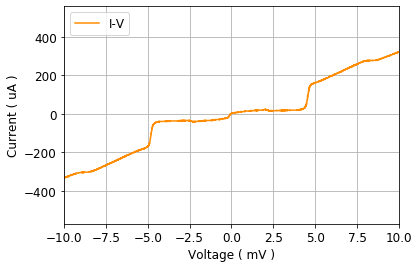

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(data.coords['sisvol'], data.values, color='darkorange', label='I-V')
ax.set_xlim(-10,10)
#ax.set_ylim(0,300)

ax.set_xlabel('Voltage ( mV )')
ax.set_ylabel('Current ( uA )')
ax.grid()
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, loc='upper left')
plt.savefig('yfactor_power.pdf')